# Question:
I wonder what a day's worth of blood glucose data ... "sounds like" ;p.

In [11]:
import sys
print(sys.version)

3.6.8 (v3.6.8:3c6b436a57, Dec 24 2018, 02:04:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [12]:
!pip freeze > requirements.txt

# Step 1
Let's load some glucose data from a json file. This json file was generated with the help of an open source project
called [Nightscout](http://www.nightscout.info/). It scrapes Glucose Data from a continuous glucose monitor that I
wear on my body called a dexcom.


In [13]:
import json
with open('./glucose.json') as f:
  raw_data = json.load(f)

In [15]:
# data clean up
glucose_values = []
for reading in raw_data:
    glucose_values.append(reading['sgv'])

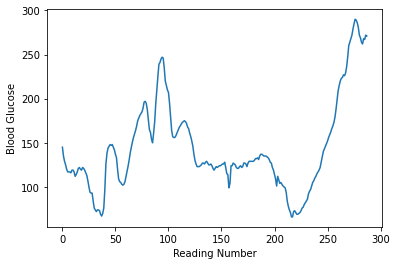

In [19]:
# Lets take a peak at a part of the data
import matplotlib.pyplot as plt
plt.plot(glucose_values)
plt.ylabel('Blood Glucose')
plt.xlabel('Reading Number')
plt.show()

# Some Background
It looks like on this particular day, my glucose numbers were a little more erratic than normal, thats okay.
It happens, not every day is perfect as a Type 1 Diabetic, and in this particular case it may actually result in a more interesting sound!

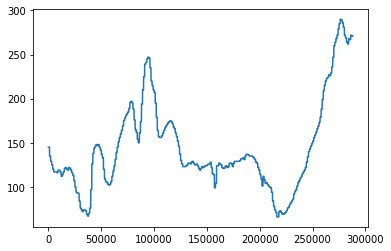

In [127]:
# We need to up-sample our 288 data points representing one day, to over 44 Thousand data points

import resampy
import numpy as np
# upsampled_glucose = resampy.resample(np.array(glucose_values), 288, 44100)
# I tried doing some fancy sampling above, but it was just way too noisy, so ima just hack a function to do it
upsampled_glucose = []
for sample in glucose_values:
    # 200
    upsampled_glucose.extend(1000*[sample])

plt.plot(upsampled_glucose)

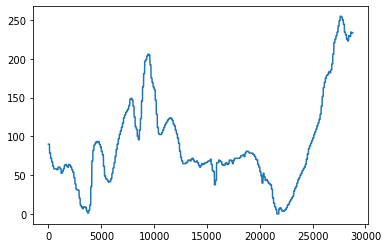

In [124]:
# ok we have the upsampled data, but we need to normalize it
from sklearn.preprocessing import minmax_scale

upsampled_glucose_scaled = minmax_scale(upsampled_glucose, feature_range=(0.0,255.0))
plt.plot(upsampled_glucose_scaled)

In [125]:
# now i need to convert the data to sound

import scipy.io.wavfile as wavf

# samples = np.random.randn(44100)
samples = upsampled_glucose_scaled
fs = 22257
out_f = 'v1.wav'

wavf.write(out_f, fs, samples)
print("v1 created")

v1 created


In [126]:
# need a ref wav file to figure out what normal array values are
samplerate, taunt_sound = wavf.read('./taunt.wav')

# samples = np.random.randn(44100)
samples = taunt_sound
fs = 22257
out_f = 'control.wav'

wavf.write(out_f, fs, samples)
print("control created")


control created


OK, so at this point, the audio sounds super wonky. it doesnt actually sound like the smooth beeps i expected. now i
guess this is turning into a lesson about sound... lol. I am guessing this has something to do with not acutally
generating anything that is sinusodal like. so lets see if we can do that.

In [132]:
# Gunna try just hand generating sine waves lol

sampling_rate = 44100
freq = 400
samples = 44100
x = np.arange(samples)

# sin wave
y = 100*np.sin(2 * np.pi * freq * x / sampling_rate)

wavf.write('test.wav', sampling_rate, y)


In [156]:
# OK so lets map each glucose value to a freq and sin wave

glucose_music = []

# og values
# sampling_rate = 44100
# samples = 44100
sampling_rate = 44100
samples = 44100
x = np.arange(samples)

for reading in glucose_values:
    # sin wave
    y = 100*np.sin(2 * np.pi * reading * x / sampling_rate)
    glucose_music.append(y)

glucose_music_final = np.concatenate(glucose_music)
wavf.write('glucose-v1.wav', sampling_rate, glucose_music_final)
print("Music generated")

Music generated


# IT Worked!
Holy cow it freakin worked. I had to manually jam sin waves together at frequences based on glucose, but it worked.
I am not going to clean this notebook up much, because I feel like its a good record of trying different things, and
just rolling with it till it works.

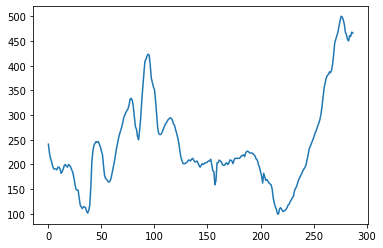

In [162]:
# theres one more thing i want to do.
# when i play through my headphones, it sounds fine, but playing through my computer it seems to clip a lot.
# let me see what i can do...

# if an A is a sine wave at 440 hz, i should probably stay around there
# according to this site: https://www.szynalski.com/tone-generator/ tones can be anywhere from 5 hz to 1500 hz

glucose_values_normalized = minmax_scale(glucose_values, feature_range=(100,500.0))
plt.plot(glucose_values_normalized)

In [171]:
# actually scratch that, i have one more option
# found this thing called pydub, lets see if it helps
# https://medium.com/better-programming/simple-audio-processing-in-python-with-pydub-c3a217dabf11


from pydub import AudioSegment
from pydub.generators import Sine
# Create an empty segment to store our result
result = AudioSegment.silent(duration=0)
for n in glucose_values:

    # Generate a sine tone with frequency 200 * n
    gen = Sine(3 * n)

    # Turn the tone into an AudioSegment with duration 200ms and gain -3
    sine = gen.to_audio_segment(duration=100).apply_gain(-3)

    # Fade in / out
    sine = sine.fade_in(50).fade_out(100)

    # Append the sine to our result
    result += sine

# Save the result to an MP3 file
result.export("glucose.mp3", format="mp3")
print("final song generated")

final song generated


# Done... For now!
OK, it sounds way better. The final version is available as glucose.mp3 ! In summary, we pulled a day's worth of
glucose data from a continuous glucose monitor that I wear using a tool called nightscout. Using that data, I attempted
to manually generate sine waves based on the glucose reading, then after some searching, I found a way nicer way to
generate those tones and output them as mp3.
If it all sounds a little hectic, thats because life with Type 1 Diabetes can be! ;p
Anyway, hope you enjoyed this fun little project.